In [1]:
# 注意⼒汇聚：Nadaraya-Watson 核回归
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
# 生成数据集
''' 
在这⾥⽣成了50个训练样本和50个测试样本。为了更好地可视
化之后的注意⼒模式，需要将训练样本进⾏排序
'''
n_train = 50 # 训练样本数
x_train, _ = torch.sort(torch.rand(n_train) * 5) # 排序后的训练样本

def f(x): # 构建一个非线性函数用于生成人工数据集
    return 2 * torch.sin(x) + x**0.8

# 训练样本的输出,f(x) + 噪声项 ϵ
y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,)) # 训练样本

# 生成 50 个测试样本
x_test = torch.arange(0, 5, 0.1) # 测试样本
y_truth = f(x_test) # 测试样本的真实输出
n_test = len(x_test) # 测试样本数
n_test # 展示测试样本数

50

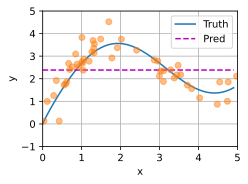

In [3]:
'''下⾯的函数将绘制所有的训练样本（样本由圆圈表⽰），不带噪声项的真实数据⽣成函数f（标记为“Truth”），
以及学习得到的预测函数(标记为“Pred”)
'''
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

# 基于平均汇聚来计算所有训练样本输出值的平均值：
y_hat = torch.repeat_interleave(y_train.mean(), n_test) # 平均汇聚
plot_kernel_reg(y_hat) # 绘制所有的训练样本

In [7]:
# 非参数注意力汇聚 -> Nadaraya-Watson核回归
''' 
显然，平均汇聚忽略了输⼊xi。于是Nadaraya (Nadaraya, 1964)和 Watson (Watson, 1964)提出了⼀个更好的
想法，根据输⼊的位置对输出yi进⾏加权

如果⼀个键xi越是接近给定的查询x，那么分配给这个键对应值yi的注意⼒权重就会越⼤，也
就“获得了更多的注意⼒”

值得注意的是，Nadaraya-Watson核回归是⼀个⾮参数模型。因此，(10.2.6)是 ⾮参数的注意⼒汇聚
(nonparametric attention pooling)模型。接下来，我们将基于这个⾮参数的注意⼒汇聚模型来绘制预测
结果。从绘制的结果会发现新的模型预测线是平滑的，并且⽐平均汇聚的预测更接近真实
'''
# X_repeat的形状:(n_test,n_train),
# 每⼀⾏都包含着相同的测试输⼊（例如：同样的查询）
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# x_train包含着键。attention_weights的形状：(n_test,n_train),
# 每⼀⾏都包含着要在给定的每个查询的值（y_train）之间分配的注意⼒权重
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
attention_weights

tensor([[5.4067e-02, 5.3732e-02, 5.1970e-02,  ..., 7.0821e-07, 6.4656e-07,
         2.2718e-07],
        [5.0053e-02, 5.0156e-02, 4.9327e-02,  ..., 1.0499e-06, 9.6032e-07,
         3.4475e-07],
        [4.6232e-02, 4.6711e-02, 4.6712e-02,  ..., 1.5528e-06, 1.4231e-06,
         5.2197e-07],
        ...,
        [1.7224e-06, 2.5248e-06, 5.3462e-06,  ..., 9.1963e-02, 9.1872e-02,
         8.8603e-02],
        [1.1541e-06, 1.7058e-06, 3.6726e-06,  ..., 9.8670e-02, 9.8762e-02,
         9.7316e-02],
        [7.6948e-07, 1.1468e-06, 2.5106e-06,  ..., 1.0535e-01, 1.0565e-01,
         1.0636e-01]])

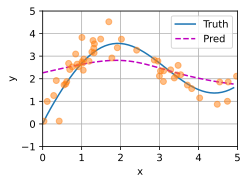

In [8]:
# y_hat的每个元素都是值的加权平均值，其中的权重是注意⼒权重
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

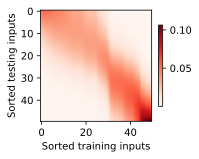

In [5]:
'''现在来观察注意力的权重。这⾥测试数据的输⼊相当于查询，⽽训练数据的输⼊相当于键。因为两个输⼊都
是经过排序的，因此由观察可知“查询-键”对越接近，注意⼒汇聚的注意⼒权重就越⾼
'''
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

In [9]:
# 带参数注意力汇聚
'''⾮参数的Nadaraya-Watson核回归具有⼀致性（consistency）的优点：如果有⾜够的数据，此模型会收敛到
最优结果。尽管如此，我们还是可以轻松地将可学习的参数集成到注意⼒汇聚中.

例如，在下⾯的查询x和键xi之间的距离乘以可学习参数w,
本节的余下部分将通过训练这个模型 (10.2.7)来学习注意⼒汇聚的参数'''
# 批量矩阵乘法
'''为了更有效地计算⼩批量数据的注意⼒，我们可以利⽤深度学习开发框架中提供的批量矩阵乘法。
假设第⼀个⼩批量数据包含n个矩阵X1,..., Xn，形状为a × b，第⼆个⼩批量包含n个矩阵Y1,..., Yn，形状
为b × c。它们的批量矩阵乘法得到n个矩阵 X1Y1,..., XnYn，形状为a × c。因此，假定两个张量的形状分别
是(n, a, b)和(n, b, c)，它们的批量矩阵乘法输出的形状为(n, a, c)
'''
X = torch.ones((2, 1, 4)) # (n, a, b)
Y = torch.ones((2, 4, 6)) # (n, b, c)
torch.bmm(X, Y).shape # (n, a, c)

torch.Size([2, 1, 6])

In [10]:
'在注意⼒机制的背景中，我们可以使⽤⼩批量矩阵乘法来计算⼩批量数据中的加权平均值'
weights = torch.ones((2, 10)) * 0.1 # 权重 Q K
values = torch.arange(20.0).reshape((2, 10)) # 值 V
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1)) # 计算两个tensor的矩阵乘法

tensor([[[ 4.5000]],

        [[14.5000]]])

In [11]:
#定义模型
'基于 (10.2.7)中的带参数的注意⼒汇聚，使⽤⼩批量矩阵乘法，定义Nadaraya-Watson核回归的带参数版本为：'
class NWKernelRegression(nn.Module): # NW核回归模型
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True)) # 回归添加的参数
        
    def forward(self, queries, keys, values): # 前向传播进行核回归计算
        # queries和attention_weights的形状为(查询个数 "键－值"对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1) # 使用Q, K 计算注意力权重
        # values 的形状为(查询个数, "键－值"对个数)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1) # 使用小批量矩阵乘法计算加权平均值

In [12]:
# 训练
'''接下来，将训练数据集变换为键和值⽤于训练注意力模型。在带参数的注意⼒汇聚模型中，任何⼀个训练样
本的输⼊都会和除⾃⼰以外的所有训练样本的“键－值”对进行计算，从而得到其对应的预测输出'''
# X_tile的形状:(n_train，n_train)，每⼀行都包含着相同的训练输⼊
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每⼀行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

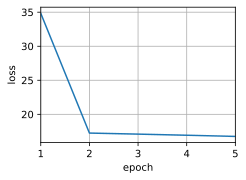

In [14]:
'训练带参数的注意⼒汇聚模型时，使⽤平方损失函数和随机梯度下降'
net = NWKernelRegression() # NW核回归模型
loss = nn.MSELoss(reduction='none') # 平方损失函数
trainer = torch.optim.SGD(net.parameters(), lr=0.5) # 随机梯度下降
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

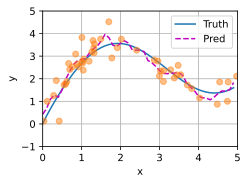

In [15]:
'''如下所示，训练完带参数的注意⼒汇聚模型后可以发现：在尝试拟合带噪声的训练数据时，预测结果绘制的
线不如之前⾮参数模型的平滑
'''
# keys的形状:(n_test，n_train)，每⼀⾏包含着相同的训练输⼊（例如，相同的键）
keys = x_train.repeat((n_test, 1)) # 0维复制n_test次,1维复制1次
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

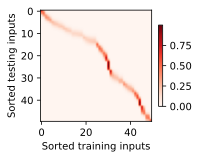

In [16]:
'''为什么新的模型更不平滑了呢？下⾯看⼀下输出结果的绘制图：与⾮参数的注意⼒汇聚模型相⽐，带参数的
模型加⼊可学习的参数后，曲线在注意⼒权重较⼤的区域变得更不平滑
'''
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
xlabel='Sorted training inputs',
ylabel='Sorted testing inputs')


In [ ]:
'''⼩结
• Nadaraya-Watson核回归是具有注意⼒机制的机器学习范例
• Nadaraya-Watson核回归的注意⼒汇聚是对训练数据中输出的加权平均。从注意力的⻆度来看，分配给
每个值的注意⼒权重取决于将值所对应的键和查询作为输⼊的函数
• 注意⼒汇聚可以分为非参数型和带参数型
'''